Question 2

In [320]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import time

LSH

In [321]:
class LSH:
    def __init__(self, data, n_hyperplanes, k, l):
        self.data = data
        self.n_hyperplanes = n_hyperplanes
        self.k = k
        self.l = l
        self.hyperplane_sets = [np.random.randn(n_hyperplanes, data.shape[1] + 1) for _ in range(l)]
        self.buckets = [{} for _ in range(l)]

    def _hash(self, vector, hyperplanes):
        projection = np.dot(hyperplanes, np.append(vector, 1))
        binary_hash = ''.join('1' if i > 0 else '0' for i in projection)
        return binary_hash

    def add_items(self, vectors):
        for l_index in range(self.l):
            for item_id, item_vector in enumerate(vectors):
                hash_key = self._hash(item_vector, self.hyperplane_sets[l_index])
                if hash_key in self.buckets[l_index]:
                    self.buckets[l_index][hash_key].append(item_id)
                else:
                    self.buckets[l_index][hash_key] = [item_id]

    def query(self, query_vector):
        candidate_items_set = set()
        for l_index in range(self.l):
            hash_key = self._hash(query_vector, self.hyperplane_sets[l_index])
            candidate_items_set.update(self.buckets[l_index].get(hash_key, []))

        candidate_items = list(candidate_items_set)
        distances = [(item_id, distance.euclidean(self.data[item_id], query_vector))
                     for item_id in candidate_items]
        sorted_distances = sorted(distances, key=lambda x: x[1])
        k_closest_items = sorted_distances[:self.k]
        return k_closest_items, candidate_items

Time Complexity: $ O(k*D + D*n/2^k) $, for $ k = logn $, it is approx $ O(Dlog(n)) $


Naive

In [322]:
class Naive_KNN:
    def __init__(self, data, k):
        self.data = data
        self.k = k
        
    def query(self, query_vector):
        distances = [(item_id, distance.euclidean(self.data[item_id], query_vector)) for item_id in range(self.data.shape[0])]
        sorted_distances = sorted(distances, key=lambda x: x[1])
        k_closest_items = sorted_distances[:self.k]
        return k_closest_items

Time Complexity = $ O(n*D) $



KD Tree

In [323]:
import numpy as np

class KDNode:
    def __init__(self, points, point, dimension, left=None, right=None):
        self.points = points
        self.point = point  
        self.dimension = dimension  
        self.left = left
        self.right = right

class KDTree:
    def __init__(self, points, k, min_size=1):
        self.k = k
        self.min_size = min_size  # Minimum size to stop recursion
        self.root = self.build_tree(points, depth=0)

    def build_tree(self, points, depth):
        if len(points) <= self.min_size:  # Stop recursion for small nodes
            return None
        
        k = points.shape[1]
        axis = depth % k
        sorted_points = points[np.argsort(points[:, axis])]
        median_index = len(sorted_points) // 2

        return KDNode(
            points=sorted_points,
            point=sorted_points[median_index],
            dimension=axis,
            left=self.build_tree(sorted_points[:median_index], depth + 1),
            right=self.build_tree(sorted_points[median_index + 1:], depth + 1)  # Skip median
        )
    
    def query(self, query_point):
        leaf_node = self.search(query_point, self.root)
        candidate_points = leaf_node.points
        distances = [(item_id, distance.euclidean(item, query_point)) for 
                     item_id, item in enumerate(candidate_points)]
        sorted_distances = sorted(distances, key=lambda x: x[1])
        k_closest_items = sorted_distances[:self.k]
        return k_closest_items, candidate_points
        
    def search(self, query_point, node):
        if node is None:
            return None
        if node.left is None and node.right is None:
            return node
        axis = node.dimension
    
        if query_point[axis] < node.point[axis]:
            return self.search(query_point, node.left)
        else:
            return self.search(query_point, node.right)



Time Complexity: $ O(log(n) + D*S) $


In [324]:
np.random.seed(42)
data = np.random.rand(100, 2)
query_vector = np.random.rand(2)
print(data.size)
print(data.itemsize)
print(query_vector.size)
print(query_vector.itemsize)

200
8
2
8


Naive Algorithm

[[0.59241457 0.04645041]
 [0.61185289 0.13949386]
 [0.67756436 0.01658783]]


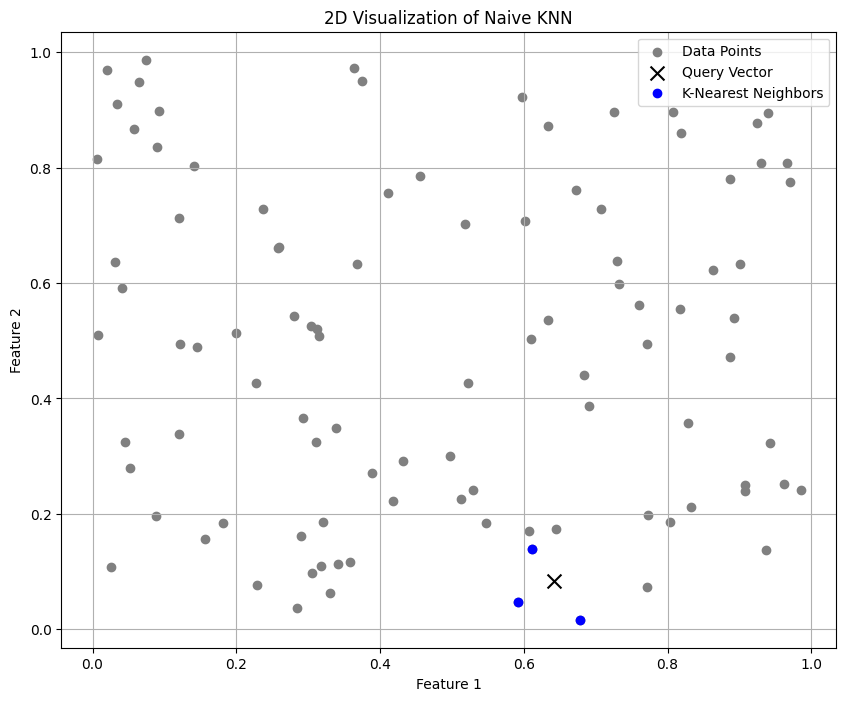

(None,
 [(14, 0.06230856048504454),
  (10, 0.0630461006121249),
  (85, 0.07632735401810006)])

In [325]:
naive_knn = Naive_KNN(data, 3)
result = naive_knn.query(query_vector)

nearest_ids = [item[0] for item in result]
nearest_coords = data[nearest_ids]
nearest_points_naive = np.array(nearest_coords)
print(nearest_points_naive)
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], color='gray', label='Data Points')
plt.scatter([query_vector[0]], [query_vector[1]], color='black', marker='x', s=100, label='Query Vector')
plt.scatter(nearest_coords[:, 0], nearest_coords[:, 1], color='blue', label='K-Nearest Neighbors')

plt.title('2D Visualization of Naive KNN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show(), result

So the true three closest points are :
[[0.59241457 0.04645041]
 [0.61185289 0.13949386]
 [0.67756436 0.01658783]]


In [326]:
#Memory
import numpy as np
import sys
import matplotlib.pyplot as plt

def memory_usage_naive_knn(data, query_vector, nearest_coords, k):
    # Memory for dataset
    data_memory = data.size * data.itemsize

    # Memory for query vector
    query_vector_memory = query_vector.size * query_vector.itemsize

    # Memory for distance calculations (temporary array)
    distance_memory = data.shape[0] * 8  # Assuming np.float64 (8 bytes per distance)

    # Memory for nearest neighbor indices
    nearest_ids_memory = k * sys.getsizeof(int())

    # Memory for nearest neighbor coordinates
    nearest_coords_memory = nearest_coords.size * nearest_coords.itemsize

   

    # Total memory
    total_memory = (
        data_memory + query_vector_memory + distance_memory +
        nearest_ids_memory + nearest_coords_memory )

    return {
        # "Data Memory (bytes)": data_memory,
        # "Query Vector Memory (bytes)": query_vector_memory,
        # "Distance Memory (bytes)": distance_memory,
        # "Nearest IDs Memory (bytes)": nearest_ids_memory,
        # "Nearest Coords Memory (bytes)": nearest_coords_memory,
        
        "Total Memory (bytes)": total_memory,
    }

# Example Usage
np.random.seed(42)
data = np.random.rand(100, 2)  # Dataset with 100 points and 2 dimensions
query_vector = np.random.rand(2)  # Query vector
k = 3

# Assuming Naive_KNN is implemented
naive_knn = Naive_KNN(data, k)
result = naive_knn.query(query_vector)
nearest_ids = [item[0] for item in result]
nearest_coords = data[nearest_ids]

# Calculate memory usage
memory_stats = memory_usage_naive_knn(data, query_vector, nearest_coords, k)
print(memory_stats)


{'Total Memory (bytes)': 2548}


KD Tree Implementation

[[0.59241457 0.04645041]
 [0.61185289 0.13949386]
 [0.67756436 0.01658783]]


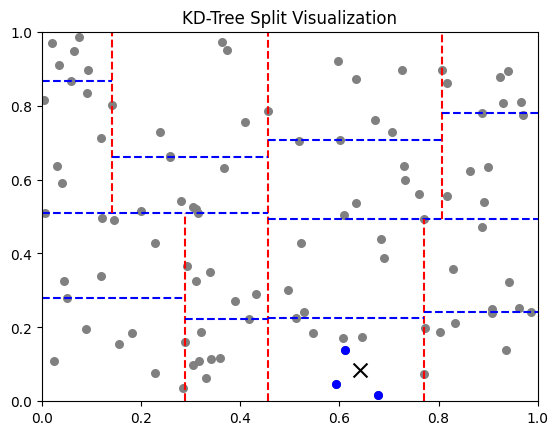

(None,
 [(1, 0.06230856048504454), (2, 0.0630461006121249), (0, 0.07632735401810006)])

In [327]:
min_points = 10
k = 3

tree = KDTree(data, k, min_points)
result, candidate_points = tree.query(query_vector)

def plot_kd_tree(node, min_x, max_x, min_y, max_y, depth=0):
    if node is not None:
        if depth % 2 == 0:
            plt.plot([node.point[0], node.point[0]], [min_y, max_y], '--', color='red')
            plot_kd_tree(node.left, min_x, node.point[0], min_y, max_y, depth + 1)
            plot_kd_tree(node.right, node.point[0], max_x, min_y, max_y, depth + 1)
        else:
            plt.plot([min_x, max_x], [node.point[1], node.point[1]], '--', color='blue')
            plot_kd_tree(node.left, min_x, max_x, min_y, node.point[1], depth + 1)
            plot_kd_tree(node.right, min_x, max_x, node.point[1], max_y, depth + 1)

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=30, c='grey', label='Data points')
ax.scatter(query_vector[0], query_vector[1], s=100, marker='x', c='black', label='Query point')
for value in result:
    point = candidate_points[value[0]]
    ax.scatter(point[0], point[1], s=30, c='blue', label='Nearest Neighbour')
plot_kd_tree(tree.root, 0, 1, 0, 1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('KD-Tree Split Visualization')

nearest_points_KD = np.array([candidate_points[idx] for idx, _ in result])
print(nearest_points_KD)
# ax.legend()
plt.show(), result

In [328]:
missing_points = np.array([
    row for row in nearest_points_naive if not any(np.all(row == nearest_points_KD, axis=1))
])
print(missing_points)

[]


In [329]:
# Memory 
import numpy as np
import sys
import matplotlib.pyplot as plt

def memory_usage_kd_tree(data, query_vector, kd_tree):
    # Memory for the dataset
    data_memory = data.size * data.itemsize

    # Estimate memory for tree nodes (simplified approximation)
    num_nodes = 2 * data.shape[0] - 1  # Approx number of nodes in a balanced KD-Tree
    node_metadata_size = sys.getsizeof(kd_tree.root)  # Estimate size of one node
    tree_nodes_memory = num_nodes * node_metadata_size

    # Memory for the query vector
    query_vector_memory = query_vector.size * query_vector.itemsize

    

    # Total memory usage
    total_memory = (
        data_memory + tree_nodes_memory + query_vector_memory 
    )

    return {
        # "Data Memory (bytes)": data_memory,
        # "Tree Nodes Memory (bytes)": tree_nodes_memory,
        # "Query Vector Memory (bytes)": query_vector_memory,
        
        "Total Memory (bytes)": total_memory,
    }

# Example Usage
np.random.seed(42)
data = np.random.rand(100, 2)
query_vector = np.random.rand(2)

# Assuming KDTree is already implemented
kd_tree = KDTree(data, k=3)  # Example KD-Tree initialization
memory_stats = memory_usage_kd_tree(data, query_vector, kd_tree)

print(memory_stats)


{'Total Memory (bytes)': 12760}


LSH Implementation

[[0.59241457 0.04645041]
 [0.67756436 0.01658783]
 [0.77127035 0.07404465]]


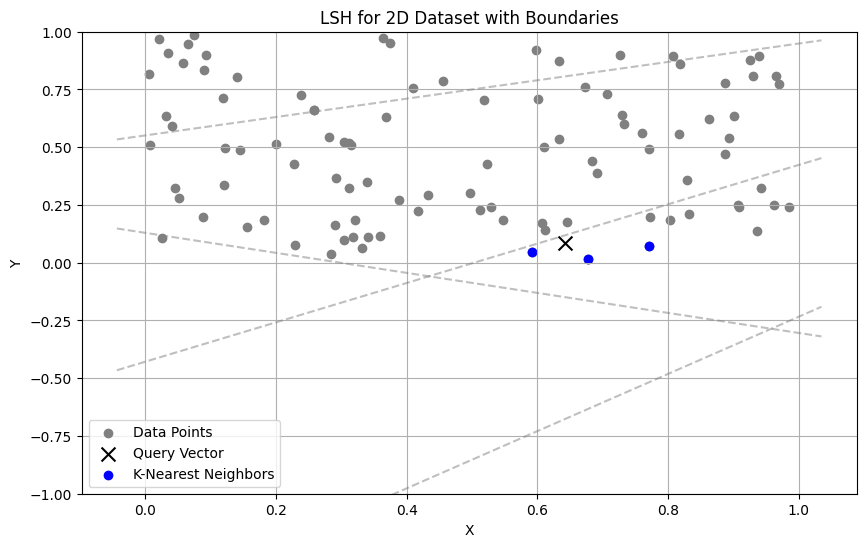

(None,
 [(14, 0.06230856048504454),
  (85, 0.07632735401810006),
  (38, 0.12963239203589685)])

In [330]:
def plot_boundaries(ax, hyperplanes, xlim, ylim):
    for plane in hyperplanes:
        if plane[1] == 0:
            continue
        slope = -plane[0] / plane[1]
        intercept = -plane[2] / plane[1]
        x_vals = np.linspace(xlim[0], xlim[1], 100)
        y_vals = slope * x_vals + intercept
        ax.plot(x_vals, y_vals, linestyle='--', color='gray', alpha=0.5)
        
lsh = LSH(data, n_hyperplanes=5, k=3, l=1)
lsh.add_items(data)
result, candidate_items = lsh.query(query_vector)
nearest_ids = [item[0] for item in result]
nearest_coords = data[nearest_ids]
candidate_coords = data[candidate_items]
nearest_points_LSH = np.array(nearest_coords)
print(nearest_points_LSH)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data[:, 0], data[:, 1], c='grey', label='Data Points')
ax.scatter(query_vector[0], query_vector[1], c='black', label='Query Vector', marker='x', s=100)
ax.scatter(nearest_coords[:, 0], nearest_coords[:, 1], color='blue', label='K-Nearest Neighbors')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
for hyperplanes in lsh.hyperplane_sets:
    plot_boundaries(ax, hyperplanes, xlim, ylim)

ax.set_title('LSH for 2D Dataset with Boundaries')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.ylim(-1,1)
plt.show(), result

Memory Analysis of LSH

In [331]:
#Memory
import sys
import numpy as np

def memory_usage_plot(data, query_vector, lsh, nearest_coords, candidate_coords):
    # Memory for data
    data_memory = data.size * data.itemsize
    
    # Memory for hyperplanes
    hyperplanes_memory = sum(
        [h.size * h.itemsize for h in lsh.hyperplane_sets]
    )
    
    # Memory for buckets (approximation)
    bucket_memory = sum(
        [sys.getsizeof(bucket) for bucket in lsh.buckets]
    )
    
    # Memory for query vector
    query_vector_memory = query_vector.size * query_vector.itemsize
    
    # Memory for nearest_coords and candidate_coords
    nearest_coords_memory = nearest_coords.size * nearest_coords.itemsize
    candidate_coords_memory = candidate_coords.size * candidate_coords.itemsize

    # Total memory
    total_memory = (
        data_memory + hyperplanes_memory + bucket_memory +
        query_vector_memory + nearest_coords_memory + candidate_coords_memory
    )

    return {
        
        "Total Memory (bytes)": total_memory,
    }

# Example usage
memory_stats = memory_usage_plot(data, query_vector, lsh, nearest_coords, candidate_coords)
print(memory_stats)


{'Total Memory (bytes)': 2160}


[[0.61185289 0.13949386]]
Missing Points to Plot: [[0.61185289 0.13949386]]


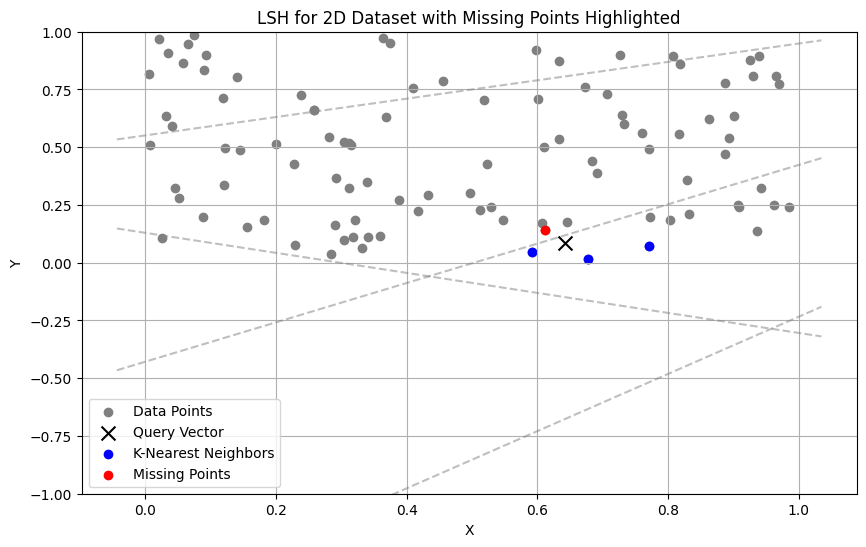

In [332]:
# Find missing points

missing_points = np.array([
    row for row in nearest_points_naive if not any(np.all(row == nearest_points_LSH, axis=1))
])
print(missing_points)
# Plot the LSH visualization with missing points highlighted
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data[:, 0], data[:, 1], c='grey', label='Data Points')
ax.scatter(query_vector[0], query_vector[1], c='black', label='Query Vector', marker='x', s=100)
ax.scatter(nearest_coords[:, 0], nearest_coords[:, 1], color='blue', label='K-Nearest Neighbors')

# Highlight missing points in red
if missing_points.size > 0:
    print("Missing Points to Plot:", missing_points)
    ax.scatter(missing_points[:, 0], missing_points[:, 1], color='red', label='Missing Points')

# Plot hyperplane boundaries
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for hyperplanes in lsh.hyperplane_sets:
    plot_boundaries(ax, hyperplanes, xlim, ylim)

ax.set_title('LSH for 2D Dataset with Missing Points Highlighted')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.grid(True)
plt.ylim(-1, 1)
plt.show()


Train and Test Time Analysis

In [333]:
import pandas as pd
def measure_performance(data, query_vector, k):
    # Naive k-NN
    start = time.time()
    naive_knn = Naive_KNN(data, k)
    naive_train_time = time.time() - start
    start = time.time()
    naive_result = naive_knn.query(query_vector)
    naive_test_time = time.time() - start

    # KD-Tree
    start = time.time()
    kd_tree = KDTree(data, k)
    kd_train_time = time.time() - start
    start = time.time()
    kd_result, _ = kd_tree.query(query_vector)
    kd_test_time = time.time() - start

    # LSH
    start = time.time()
    lsh = LSH(data, n_hyperplanes=5, k=k, l=1)
    lsh.add_items(data)
    lsh_train_time = time.time() - start
    start = time.time()
    lsh_result, _ = lsh.query(query_vector)
    lsh_test_time = time.time() - start

    return {
        "Naive Train Time": naive_train_time,
        "Naive Test Time": naive_test_time,
        "KD Train Time": kd_train_time,
        "KD Test Time": kd_test_time,
        "LSH Train Time": lsh_train_time,
        "LSH Test Time": lsh_test_time,
    }, naive_result, kd_result, lsh_result

dataset_sizes = [100, 500, 1000]
dimensions = [2, 5, 10]
results = []

for N in dataset_sizes:
    for D in dimensions:
        data = np.random.rand(N, D)
        query_vector = np.random.rand(D)
        performance, _, _, _ = measure_performance(data, query_vector, k=3)
        performance["Dataset Size"] = N
        performance["Dimensions"] = D
        results.append(performance)

performance_df = pd.DataFrame(results)
display(performance_df)

,Naive Train Time,Naive Test Time,KD Train Time,KD Test Time,LSH Train Time,LSH Test Time,Dataset Size,Dimensions
0,0.0,0.000000,0.002059,0.0,0.001053,0.000000,100,2
1,0.0,0.000925,0.000000,0.0,0.001941,0.000000,100,5
2,0.0,0.000997,0.000997,0.0,0.001007,0.000988,100,10
3,0.0,0.005980,0.003985,0.0,0.004984,0.000997,500,2
4,0.0,0.002988,0.002990,0.0,0.003987,0.000997,500,5
5,0.0,0.001996,0.001991,0.0,0.003987,0.001997,500,10
6,0.0,0.004983,0.002989,0.0,0.006998,0.003966,1000,2
7,0.0,0.004983,0.002989,0.0,0.008060,0.001989,1000,5
8,0.0,0.003998,0.002976,0.0,0.007987,0.002982,1000,10
